## Training a CNN to predict Reaction-Diffusion parameters from steady state

In [1]:
import os
import pickle
import sys; sys.path.insert(0, "../..")

import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from groovy.pde import evolve, initialframe

In [2]:
# Select CPU/GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device:', device)

Device: cuda


In [3]:
# Load the generated database
folder = 'bigger_database'
files = os.listdir(folder)

images = []
targets = []

for file in tqdm(files, desc='Data', leave=False):
    with open(f"{folder}/{file}", 'rb') as f:
        image = pickle.load(f)
    target = np.asarray(file[:-4].split('_')).astype(float)
    
    # Check for NaN's
    if np.isnan(np.sum(image)) or np.isnan(np.sum(target)): continue
    
    # Ensure that the data is not complete zero
    if np.allclose(image, 0): continue
    
    # Swap the axes so that the components come first
    image = np.swapaxes(image, 0, 2)
    
    # Add to dataset
    images.append(image)
    targets.append(target)

print('Number of data points:', len(images))

Number of data points: 14227


<IPython.core.display.Javascript object>


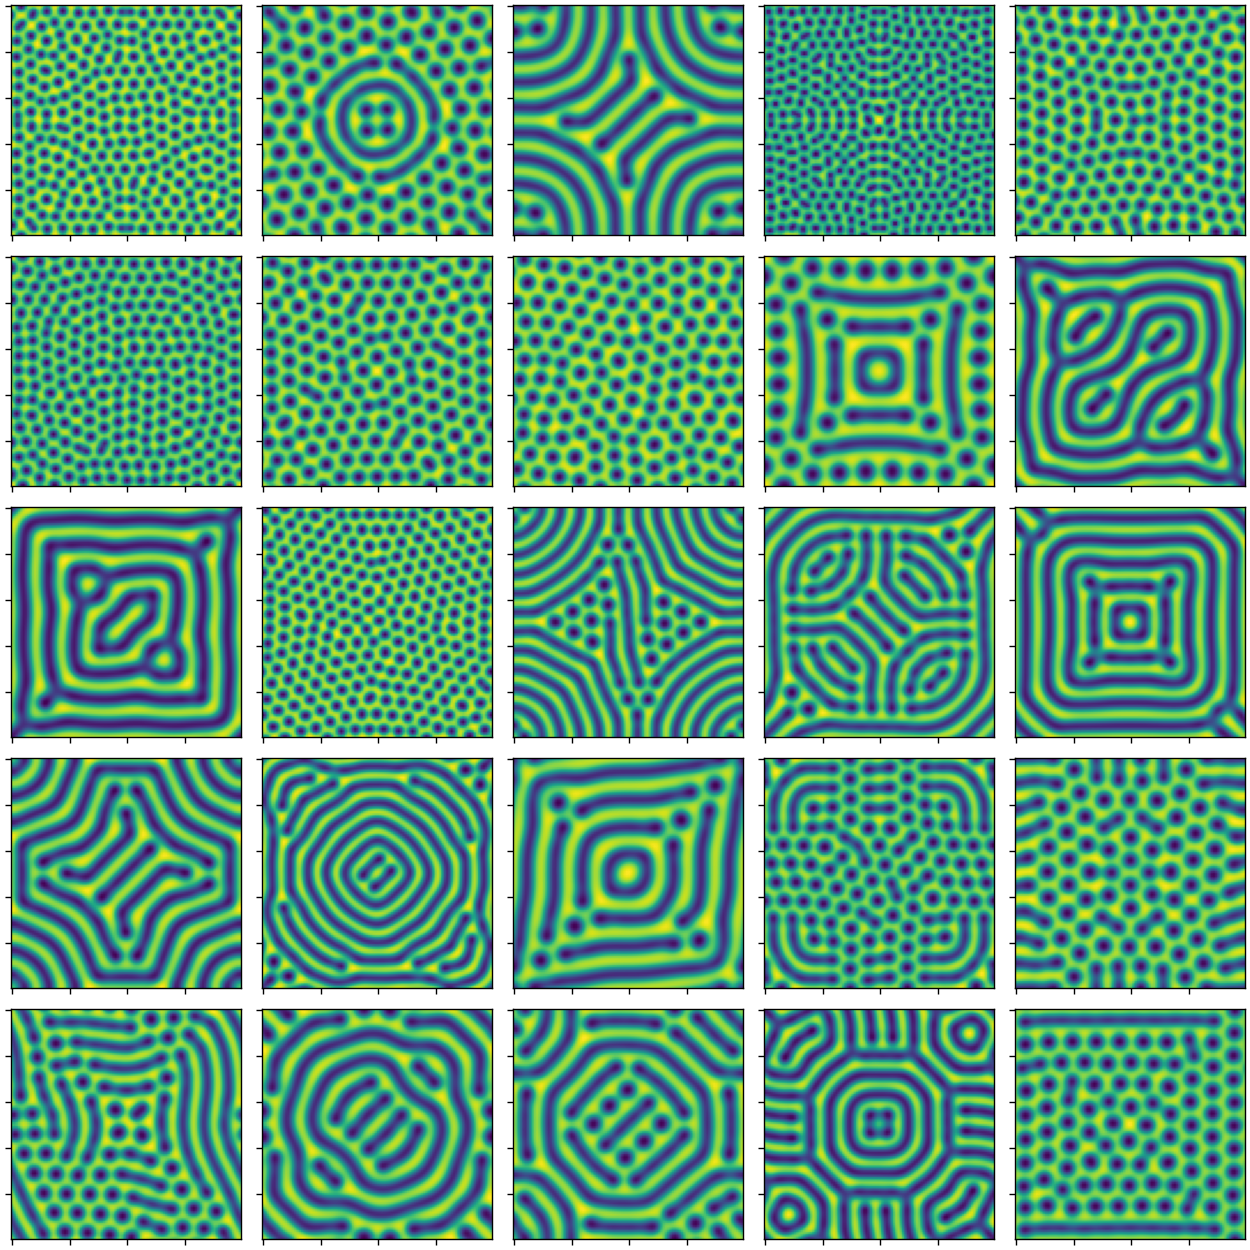

In [4]:
# Visualize a database sample
%matplotlib notebook
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10), constrained_layout=True)
for i, axis in enumerate(axes):
    for ax, img, targ in zip(axis, images[i*5 : (i+1)*5], targets[i*5 : (i+1)*5]):
        ax.imshow(img[0,:,:])
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.savefig('figs/dataset.png')

In [5]:
class MyDataset(Dataset):

    def __init__(self, X, Y):
        super().__init__()
        self.X = X
        self.Y = Y

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.from_numpy(self.Y[idx])

    def __len__(self):
        return len(self.X)


# Split the data into train, validation, test
X_trv,   X_test, Y_trv,   Y_test = train_test_split(images, targets, train_size=0.8)
X_train, X_val,  Y_train, Y_val  = train_test_split(images, targets, train_size=0.75)

# Convert to Pytorch data loaders
batch_size = 100
training   = DataLoader(MyDataset(X_train, Y_train), batch_size=batch_size)
validation = DataLoader(MyDataset(X_val,   Y_val),   batch_size=batch_size)
test       = DataLoader(MyDataset(X_test,  Y_test),  batch_size=batch_size)

In [6]:
# Define our CNN
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(100*100*2, 4)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.sig(self.fc(out))
        return out

In [7]:
# Training parameters
num_epochs = 250
learning_rate = 0.0001

# Model, loss, and optimizer
cnn = CNN()
cnn = cnn.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

# Train the model
validation_losses = []
for epoch in tqdm(range(num_epochs), desc='Epochs', leave=False):

    # Training loss
    cnn.train()
    for i, (images, targets) in enumerate(tqdm(training, desc='Train batches', leave=False)):

        images, targets = images.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
        outputs = cnn(images)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loss
    cnn.eval()
    epoch_losses = []
    for i, (images, targets) in enumerate(tqdm(validation, desc='Validation batches', leave=False)):

        images, targets = images.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
        outputs = cnn(images)
        loss_val = criterion(outputs, targets).item()
        epoch_losses.append(loss_val)

    # Early stopping
    patience = 7
    validation_losses.append(np.mean(epoch_losses))
    if len(validation_losses) >= patience and np.argmin(validation_losses[-patience:]) == 0:
        print(f"Early stopping at epoch {epoch} out of {num_epochs} total.")
        break

else:
    print(f"No early stopping used. Completed {num_epochs} epochs.")

# Test set
cnn.eval()
test_losses = []
for i, (images, targets) in enumerate(tqdm(test, desc='Test batches', leave=False)):

    images, targets = images.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
    outputs = cnn(images)
    loss_val = criterion(outputs, targets).item()
    test_losses.append(loss_val)

Early stopping at epoch 19 out of 250 total.


<IPython.core.display.Javascript object>


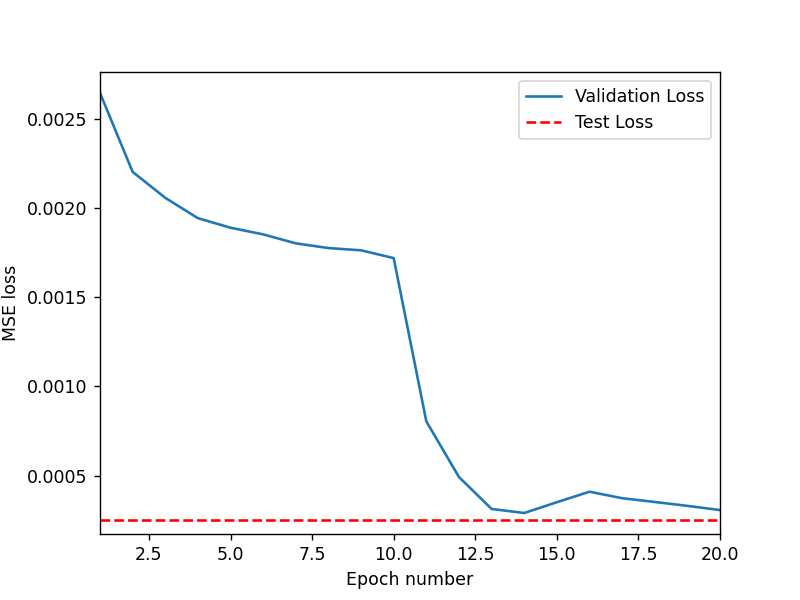

In [8]:
# Plot the training curve
%matplotlib notebook
plt.plot(np.arange(len(validation_losses)) + 1, validation_losses, label='Validation Loss')
plt.axhline(np.mean(test_losses), c='r', linestyle='--', label='Test Loss')
plt.xlabel('Epoch number')
plt.ylabel('MSE loss')
plt.xlim([1, len(validation_losses)])
plt.legend()
plt.savefig('figs/training.png')

In [40]:
def compare_CNN_evolve(image, targets, preds, fname):
    """
    Compare the CNN predictions to real evolution.
    """
    fig, ax = plt.subplots(1, 2, constrained_layout=True)
    
    # Plot the input image
    ax[0].set_title('Input steady state')
    ax[0].imshow(image, cmap='inferno')
    ax[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax[0].set_xlabel(f"ru={targets[0]:.3f}, rv={targets[1]:.3f}")
    ax[0].set_ylabel(f"f={targets[2]:.3f}, k={targets[3]:.3f}")
    
    # Do the animation
    inp = initialframe((100,100))
    time_array = evolve(inp,*preds) #Change in concentration of both chemicals over time. 
    distribution = time_array[:,:,:,1] #Change in concentration of chemical V over time.

    #Plotting:
    ax[1].set_title('CNN Predicted Evolution')
    image = ax[1].imshow(distribution[:,:,0], cmap='inferno',origin='lower',vmin=np.amin(distribution), vmax=np.amax(distribution)*0.5)
    ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax[1].set_xlabel(f"ru={preds[0]:.3f}, rv={preds[1]:.3f}")
    ax[1].set_ylabel(f"f={preds[2]:.3f}, k={preds[3]:.3f}")

    #Animating:
    def update(frame):
        image.set_data(distribution[:,:,frame]) #Progress to next slice of distribution

    frames = len(time_array[0,0])
    fps = 60
    animator = animation.FuncAnimation(fig, update, frames=frames, interval=1000/fps, repeat=True, cache_frame_data=False)
    animator.save(fname, writer='imagemagick', fps=fps)
    plt.show()

<IPython.core.display.Javascript object>


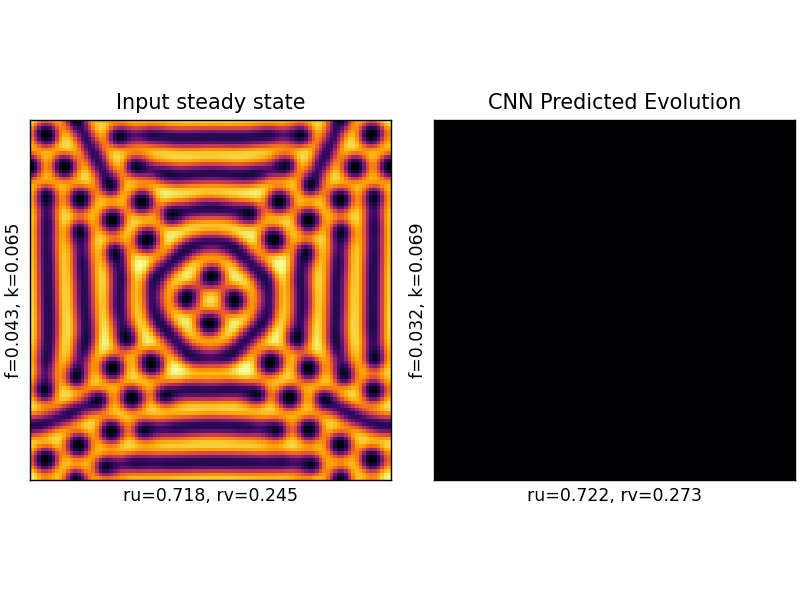

In [41]:
# Extract sample test set values
%matplotlib notebook
image_1 = images.cpu()[0,0,:,:]
target_1 = targets.cpu().numpy()[0]
preds_1 = outputs.cpu().detach().numpy()[0]

compare_CNN_evolve(image_1, target_1, preds_1, 'figs/test_1.gif')

<IPython.core.display.Javascript object>


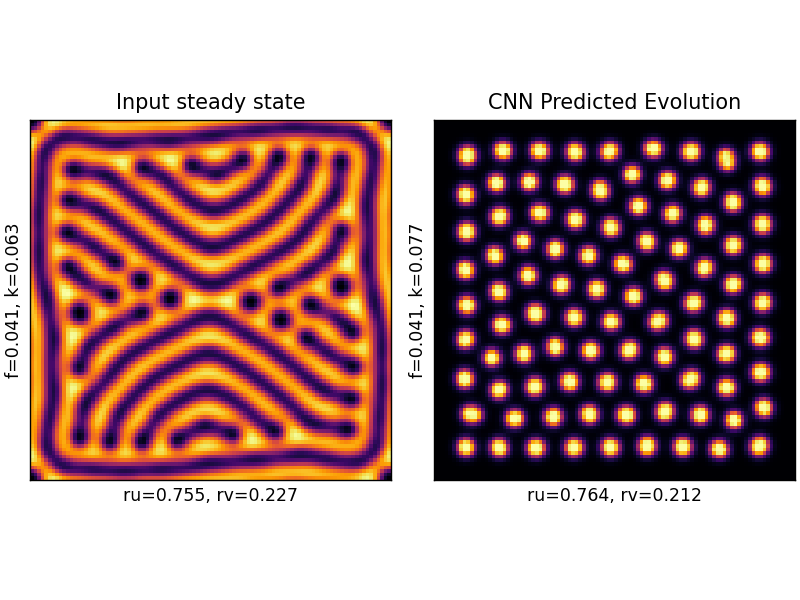

In [42]:
# Extract sample test set values
%matplotlib notebook
image_1 = images.cpu()[1,0,:,:]
target_1 = targets.cpu().numpy()[1]
preds_1 = outputs.cpu().detach().numpy()[1]

compare_CNN_evolve(image_1, target_1, preds_1, 'figs/test_2.gif')

## Animal images

In [ ]:
from glob import glob
from itertools import chain

from PIL import Image

In [ ]:
# Standardize the image inputs
def sanitize(img):
    """
    Convert a jpeg into an 100x100, 2 component image.
    """
    # Resize image
    min_length = min(img.size)
    img = img.crop((0, 0, min_length, min_length))
    img = img.resize((100, 100))

    # Convert to 2-channel pixel array
    pixel_arr = np.asarray([[r, 255-g] for r, g, b in img.getdata()]).reshape(100, 100, 2)
    return np.swapaxes(pixel_arr, 0, 2) / 256

In [ ]:
# Assemble images
labels = ['giraffe', 'leopard', 'zebra']
images = [[sanitize(Image.open(image)) for image in glob(f"patterns/{label}_*.jpg")] for label in labels]

# Reformat
images = np.asarray(list(chain.from_iterable(images)))
labels = list(chain.from_iterable([[label]*5 for label in labels]))

In [ ]:
# Demonstrate 2-component image
%matplotlib notebook
img = images[0]
plt.subplot(121)
plt.imshow(img[0,:,:])
plt.subplot(122)
plt.imshow(img[1,:,:])
plt.savefig('figs/animal_segmentation.png')

In [ ]:
# Convert Animals Pytorch data loaders
class AnimalDataset(Dataset):

    def __init__(self, X, Y):
        super().__init__()
        self.X = X
        self.Y = Y

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), self.Y[idx]

    def __len__(self):
        return len(self.X)


# Convert to Pytorch data loaders
animals = DataLoader(AnimalDataset(images, labels), batch_size=batch_size)

In [ ]:
# Animal set
cnn.eval()
for images, labels in animals:
    images = images.to(device, dtype=torch.float)
    outputs = cnn(images)

In [ ]:
# Extract sample animals
%matplotlib notebook
image_1 = images.cpu()[0,0,:,:]
target_1 = ['?', '?', '?', '?']
preds_1 = outputs.cpu().detach().numpy()[0]

compare_CNN_evolve(image_1, target_1, preds_1, 'figs/giraffe.gif')

In [ ]:
# Extract sample animals
%matplotlib notebook
image_1 = images.cpu()[5,0,:,:]
target_1 = ['?', '?', '?', '?']
preds_1 = outputs.cpu().detach().numpy()[5]

compare_CNN_evolve(image_1, target_1, preds_1, 'figs/leopard.gif')

In [ ]:
# Extract sample animals
%matplotlib notebook
image_1 = images.cpu()[10,0,:,:]
target_1 = ['?', '?', '?', '?']
preds_1 = outputs.cpu().detach().numpy()[10]

compare_CNN_evolve(image_1, target_1, preds_1, 'figs/zebra.gif')